# Simulation of station occupancy in 2016

In [1]:
import pandas as pd
import xarray as xr
import numpy as np
%matplotlib inline

## rides

Ignore the OpenStreets temporary station.

In [2]:
rides = pd.read_csv('rides2016.csv', parse_dates=['Starttime','Stoptime'])

missing = (rides['From station id'] == 1060) | (rides['To station id'] == 1060)
rides = rides.loc[~missing].copy()

## stations

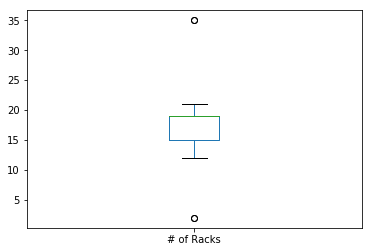

In [4]:
stations = pd.read_csv('2017-Q1/HealthyRideStations2017.csv', index_col=0)
stations['# of Racks'].plot.box()

In [18]:
stations.nlargest(4, '# of Racks')

,Station Name,# of Racks,Latitude,Longitude
Station #,,,,
1008,Centre Ave & PPG Paints Arena,35,40.440368,-79.988636
1012,North Shore Trail & Ft Duquesne Bridge,35,40.445834,-80.008882
1006,Ross St & Sixth Ave (Steel Plaza T Station),21,40.440193,-79.995084
1018,37th St & Butler St,21,40.466103,-79.964628


In [19]:
stations.nsmallest(4, '# of Racks')

,Station Name,# of Racks,Latitude,Longitude
Station #,,,,
1050,Healthy Ride Hub,2,40.461817,-79.968002
1061,33rd St and Penn Ave,2,40.462026,-79.968114
1015,Federal St & E North Ave,12,40.455091,-80.006347
1030,S Euclid Ave & Centre Ave,12,40.458933,-79.929123


## initial conditions

There are a total of 500 bikes deployed by Healthy Ride. Let's distribute them amonst the stations.

Each station can store a different number of bikes, so be certain not to exceed that.

Let's allow stations to fill in our initial conditions.

5 full stations


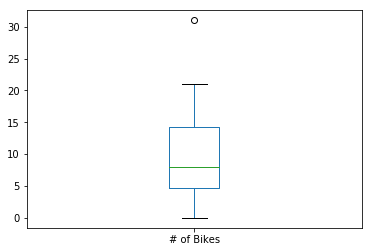

In [24]:
from itertools import cycle
import random

def initial_conditions(stations, total_bikes=500):
    init = (stations['# of Racks'] * (np.random.uniform(size=stations.shape[0]) - 0.2)).astype(np.int)
    init.name = '# of Bikes'

    total_bikes -= init.sum()

    for station in cycle(np.random.permutation(init.index)):
        n_racks = stations.loc[station, "# of Racks"]
        inc = random.randint(0, 5)
        new_count = init[station] + inc
        if new_count > n_racks:
            continue
        elif total_bikes <= 5:
            break
        else:
            init[station] = new_count
            total_bikes -= inc
    
    return init

start = initial_conditions(stations)
print('{} full stations'.format((start == stations['# of Racks']).sum()))
start.plot.box()

## bike counts in time

We'll use historic ride data to
1. Decide a frequency over which to count (Hourly, Daily, Weekly, etc.)
1. Count the number of bikes leaving a station as a negative number
1. Count the number of bikes arriving at a station as a positive number
1. The sum of the two is the change in occupancy over the frequency

In [8]:
def make_counts(rides, frequency):

    outgoing = (
        -rides.set_index('Starttime').sort_index()
         .groupby(['From station id', pd.Grouper(freq=frequency)])['Trip id'].count()
         .unstack('From station id')
    )
              
    incoming = (
        rides.set_index('Stoptime').sort_index()
         .groupby(['To station id', pd.Grouper(freq=frequency)])['Trip id'].count()
         .unstack('To station id')
    )

    delta_bikes = (outgoing + incoming).fillna(0)
    
    return delta_bikes

A full simulation is
1. Randomly distribute bikes to the stations
1. Add the change in occupancy over time to the initial distribution
1. Determine the stations that have exceeded their capacity at any time over the simulation
1. Return the station ids that filled

In [12]:
def run(rides, seed=None):
    if seed:
        np.random.seed(seed)
        
    start = initial_conditions(stations)
    
    exceeded = rides.add(start, axis='columns').ge(stations['# of Racks'], axis='columns')

    hot = stations.loc[exceeded.any(axis='rows')].reset_index()['Station #']
    return hot

Let's simulate daily counts in April 2016.

Which stations have a high likely hood of filling up each day?

In [26]:
daily = make_counts(rides, 'D').loc['Apr 2016']

hot_spots = []
n_simulations = 1000
for _ in range(n_simulations):
    hot_spots.append(run(daily))

hot_spots = pd.concat(hot_spots).value_counts() / n_simulations
hot_spots.name = 'probability filled'
stations.join(hot_spots).nlargest(10, 'probability filled')

,Station Name,# of Racks,Latitude,Longitude,probability filled
Station #,,,,,
1050,Healthy Ride Hub,2,40.461817,-79.968002,1.000
1010,10th St & Penn Ave (David L. Lawrence Conventi...,15,40.444665,-79.995798,0.873
1016,17th St & Penn Ave,19,40.449631,-79.985893,0.725
1019,42nd St & Butler St,17,40.470212,-79.960663,0.702
1000,Liberty Ave & Stanwix St,16,40.441326,-80.004679,0.701
1026,Penn Ave & S Whitfield St,13,40.461603,-79.925624,0.680
1017,21st St & Penn Ave,18,40.451742,-79.983217,0.658
1001,Forbes Ave & Market Square,19,40.440877,-80.003080,0.651
1013,Isabella St & Federal St (PNC Park),15,40.447166,-80.003566,0.639
